In [54]:
import torch
import torch.nn as nn
from PIL import Image
import os
from IPython.display import display
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms

In [79]:
class UNet_Denoise(nn.Module):

    def __init__(self):
        super(UNet_Denoise, self).__init__()

        # Convolution level 1
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # C2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # C3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # C4
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.conv5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Transposed convolution level 5
        self.transpose4 = nn.ConvTranspose2d(1024, 1024, kernel_size=3, padding=1)
        self.upconv4_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.upconv4_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # T3
        self.transpose3 = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1)
        self.upconv3_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv3_1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # T2
        self.transpose2 = nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1)
        self.upconv2_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.Tconv2_1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # T1
        self.transpose1 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.upconv1_3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.upconv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upconv1_1 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
     
    def forward(self, x):
        s1_1 = self.conv1_1(x)
        rel1 = F.relu(s1_1)
        s1_2 = self.conv1_2(rel1)
        rel2 = F.relu(s1_2)
        pooled1 = self.pool1(rel2)
    
        s2_1 = self.conv2_1(pooled1)
        rel3 = F.relu(s2_1)
        s2_2 = self.conv2_2(rel3)
        rel4 = F.relu(s2_2)
        pooled2 = self.pool2(rel4)
    
        s3_1 = self.conv3_1(pooled2)
        rel5 = F.relu(s3_1)
        s3_2 = self.conv3_2(rel5)
        rel6 = F.relu(s3_2)
        pooled3 = self.pool3(rel6)
    
        s4_1 = self.conv4_1(pooled3)
        rel7 = F.relu(s4_1)
        s4_2 = self.conv4_2(rel7)
        rel8 = F.relu(s4_2)
        pooled4 = self.pool4(rel8)

         # bottle neck
        
        s5_1 = self.conv5_1(pooled4)
        rel9 = F.relu(s5_1)
        s5_2 = self.conv5_2(rel9)
        rel10 = F.relu(s5_2)

         # after bottle neck
        
        up4 = self.transpose4(rel10)
        upconv4_2 = self.upconv4_2(up4)
        uprel4_2 = F.relu(upconv4_2)
        upconv4_1 = self.upconv4_1(uprel4_2)
        uprel4_1 = F.relu(upconv4_1)

       
    
        up3 = self.transpose3(uprel4_1)
        upconv3_2 = self.upconv3_2(up3)
        uprel3_2 = F.relu(upconv3_2)
        upconv3_1 = self.upconv3_1(uprel3_2)
        uprel3_1 = F.relu(upconv3_1)
    
        up2 = self.transpose2(uprel3_1)
        upconv2_2 = self.upconv2_2(up2)
        uprel2_2 = F.relu(upconv2_2)
        Tconv2_1 = self.Tconv2_1(uprel2_2)
        uprel2_1 = F.relu(Tconv2_1)

        up1 = self.transpose1(uprel2_1)
        upconv1_3 = self.upconv1_3(up1)
        uprel1_3 = F.relu(upconv1_3)
        upconv1_2 = self.upconv1_2(uprel1_3)
        uprel1_2 = F.relu(upconv1_2)
        upconv1_1 = self.upconv1_1(uprel1_2)
        output = F.relu(upconv1_1)
        return output

    def train(model, optimizer, loss,noisy_image, target, num_epochs):
        for epoch in range(num_epochs):
                # Forward pass
                output = model(noisy_image)
    
                # Calculate loss
                loss = loss_fn(output, target)
    
                # Backpropagation and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


<<<Initial image>>


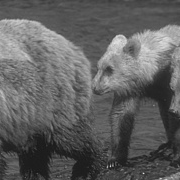

Min value: 0.08627451
Max value: 0.8980392
Width: 256
Height: 256


In [80]:

#setting up the image

image_folder = "Train400"
input_image_path = os.path.join(image_folder, "test_001.png")
input_image = Image.open(input_image_path)
print("<<<Initial image>>")
display(input_image)


# resize
resized_image = input_image.resize((256, 256))

# Convert the image to a NumPy array and normalize pixel values
image_array = np.array(resized_image)
image_array = image_array.astype(np.float32) / 255.0

clean_image = Image.fromarray((image_array * 255).astype(np.uint8))

# Check the minimum and maximum pixel values
min_value = np.min(image_array)
max_value = np.max(image_array)
width, height = resized_image.size


print("Min value:", min_value)
print("Max value:", max_value)
print("Width:", width)
print("Height:", height)



<<<Noisy normalized image>>


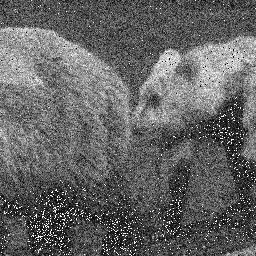

In [81]:

#noisy image generation
mean = 0
variance = 30/255

noise = np.random.normal(mean, variance, image_array.shape)

# Add noise to the image
noisy_image_array = image_array + noise

# Convert the noisy image array back to an image
noisy_image = Image.fromarray((noisy_image_array * 255).astype(np.uint8))

# Display the noisy image

print("<<<Noisy normalized image>>")
display(noisy_image)




In [83]:

model = UNet_Denoise()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed
loss_fn = nn.MSELoss()  # Choose appropriate loss function

transform = transforms.ToTensor()  # Converts image to PyTorch tensor
clean_tensor = transform(clean_image)

noisy_tensor = transform(noisy_image)

bean = UNet_Denoise.forward(model,noisy_tensor)

display(bean)

tensor([[[0.0424, 0.0421, 0.0423, 0.0424, 0.0424, 0.0424, 0.0424, 0.0424,
          0.0424, 0.0424, 0.0424, 0.0424, 0.0425, 0.0426, 0.0429, 0.0350],
         [0.0492, 0.0435, 0.0449, 0.0447, 0.0448, 0.0448, 0.0448, 0.0448,
          0.0448, 0.0448, 0.0448, 0.0447, 0.0448, 0.0448, 0.0448, 0.0325],
         [0.0492, 0.0431, 0.0452, 0.0449, 0.0449, 0.0449, 0.0449, 0.0449,
          0.0449, 0.0449, 0.0449, 0.0449, 0.0450, 0.0449, 0.0450, 0.0327],
         [0.0489, 0.0432, 0.0451, 0.0449, 0.0448, 0.0448, 0.0448, 0.0448,
          0.0448, 0.0448, 0.0448, 0.0448, 0.0448, 0.0447, 0.0451, 0.0325],
         [0.0489, 0.0431, 0.0451, 0.0448, 0.0448, 0.0448, 0.0448, 0.0448,
          0.0448, 0.0448, 0.0448, 0.0448, 0.0448, 0.0447, 0.0450, 0.0325],
         [0.0489, 0.0431, 0.0451, 0.0448, 0.0448, 0.0448, 0.0448, 0.0448,
          0.0448, 0.0448, 0.0448, 0.0448, 0.0448, 0.0446, 0.0450, 0.0324],
         [0.0489, 0.0432, 0.0451, 0.0448, 0.0448, 0.0448, 0.0448, 0.0448,
          0.0448, 0.0448, 0.0448